In [2]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

attLength=[210,120]  # cm
dE2L=[38000*0.45*0.64,9700]# BC408, EJ230 [nph/MeVe-]


NOTE
==

For BC408, [reference](https://www.crystals.saint-gobain.com/products/bc-408-bc-412-bc-416) says `LY=(40-50% of NaI(Tl)) * 0.64`

For NaI(Tl), `38 nph/keV`, which can be found [here](https://www.crystals.saint-gobain.com/sites/imdf.crystals.com/files/documents/sodium-iodide-material-data-sheet_0.pdf), is used.

EJ230's properties can be found [here](https://eljentechnology.com/products/plastic-scintillators/ej-228-ej-230)

The attenuation lengths for both scintillators can be found in the same links as above.

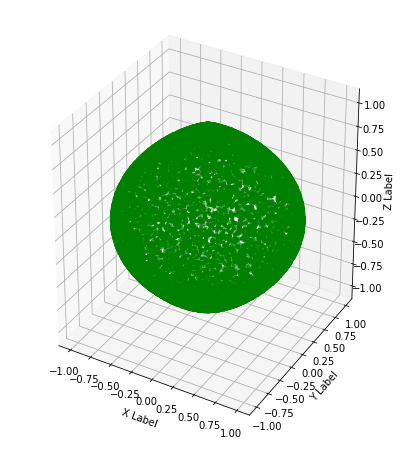

In [40]:
np.random.seed(2718)
pi=np.pi

#rnd0=np.random.random(5000)
#rnd1=np.random.random(5000)
#cos=2.0*(rnd0)-1.0
#phi=2.0*pi*(rnd1)
cos=np.random.uniform(-1,1,20000)
phi=np.random.uniform(0,2.0*pi,20000)
px=(1-cos*cos)*np.cos(phi)
py=(1-cos*cos)*np.sin(phi)
pz=cos

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(px, py, pz,s=8, c='g', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

**OK** now you generated the 4pi sperical random distribution!

**Next step** Read the given probability distribution functions for wavelength, reflactivity...

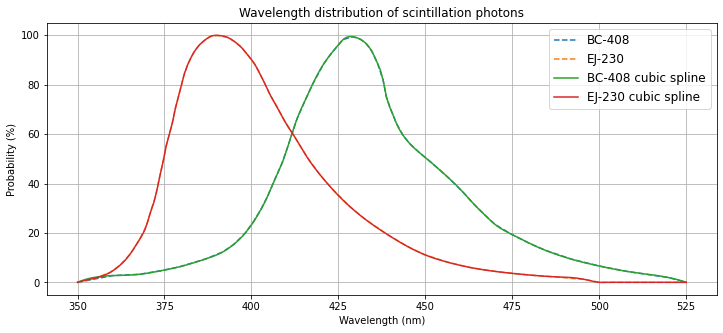

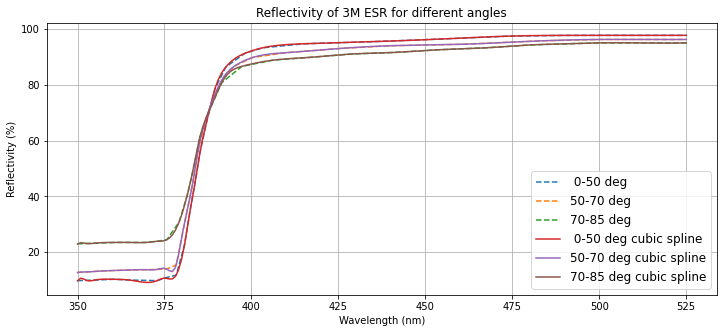

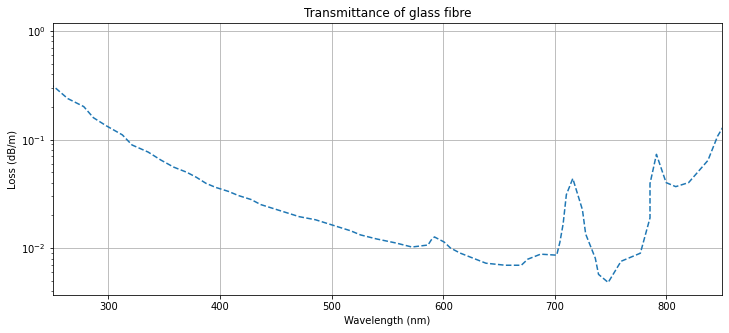

In [71]:
dataPath="prop/"
wlBC,wpBC = np.loadtxt(dataPath+"LY_BC408.txt", comments="#", delimiter="\t", unpack=True)
wlEJ,wpEJ = np.loadtxt(dataPath+"LY_EJ230.txt", comments="#", delimiter="\t", unpack=True)

#######################################################################
# NOTE; this data contains some arbitrary extrapolated points by eyes
#       to make smooth spline points. To be improved later
#######################################################################
wl3M0,wp3M0,wl3M1,wp3M1,wl3M2,wp3M2= np.loadtxt(dataPath+"3M_ref.txt", comments="#", delimiter="\t", unpack=True)


wlFib,wpFib=np.loadtxt(dataPath+"Fujikura_GlassFibre_LightAtt.txt", comments="#", delimiter="\t", unpack=True)

## Cubic spline
from scipy.interpolate import interp1d
fsp0 = interp1d(wlBC,wpBC, kind='cubic')
fsp1 = interp1d(wlEJ,wpEJ, kind='cubic')
fsp2 = interp1d(wl3M0,wp3M0, kind='cubic')
fsp3 = interp1d(wl3M1,wp3M1, kind='cubic')
fsp4 = interp1d(wl3M2,wp3M2, kind='cubic')
wl=np.linspace(350,525,200)

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(wlBC,wpBC,label='BC-408',ls='--')
ax.plot(wlEJ,wpEJ,label='EJ-230',ls='--')

ax.plot(wl,fsp0(wl),label='BC-408 cubic spline')
ax.plot(wl,fsp1(wl),label='EJ-230 cubic spline')
ax.set(xlabel='Wavelength (nm)', ylabel='Probability (%)',
       title='Wavelength distribution of scintillation photons')
ax.grid()
ax.legend(loc='upper right',fontsize='large')

plt.show()

fig, ax = plt.subplots(figsize=(12,5))

ax.plot(wl3M0,wp3M0,label=' 0-50 deg',ls='--')
ax.plot(wl3M1,wp3M1,label='50-70 deg',ls='--')
ax.plot(wl3M2,wp3M2,label='70-85 deg',ls='--')

ax.plot(wl,fsp2(wl),label=' 0-50 deg cubic spline')
ax.plot(wl,fsp3(wl),label='50-70 deg cubic spline')
ax.plot(wl,fsp4(wl),label='70-85 deg cubic spline')

ax.set(xlabel='Wavelength (nm)', ylabel='Reflectivity (%)',
       title='Reflectivity of 3M ESR for different angles')
ax.grid()
ax.legend(loc='lower right',fontsize='large')

plt.show()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(wlFib,wpFib/1000,label='Fujikura S-series',ls='--')
ax.set(xlabel='Wavelength (nm)', ylabel='Loss (dB/m)',
       title='Transmittance of glass fibre')
ax.grid()
ax.set_yscale('Log')
ax.set_xlim(250,850)

plt.show()


All data are extracted by using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/)

Some part shows instability when applying the cubic spline, so additional points are arbitrary added.

More relevant data points must be obtained later

**NOTE**
Below code has not been completed yet..

Efficiency for BC= 0.29135831245265426
Efficiency for EJ= 0.27430326969497476


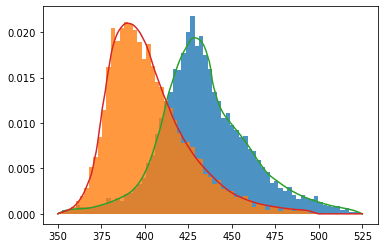

In [42]:
import scipy.stats as st

ntrial=500000

def rndomdist(ndata,x,func):
    data=[]
    eff=0
    ntry=0
    for i in range(len(x)):
        rnd=np.random.uniform(0,100)
        if(func(x[i])>rnd):
            data.append(x[i])
            eff=eff+1
        if(eff>=ndata):break
        ntry=ntry+1
    return data,float(eff/ntry)

rnd0=np.random.uniform(350,525,ntrial)

nprod=10000
dataBC,eff0=rndomdist(nprod,rnd0,fsp0)
dataEJ,eff1=rndomdist(nprod,rnd0,fsp1)
print('Efficiency for BC=',eff0)
print('Efficiency for EJ=',eff1)
xbin=np.linspace(350,525,int(175/5)*2)
plt.hist(dataBC[:],bins=xbin,density=True,alpha=0.8)
plt.hist(dataEJ[:],bins=xbin,density=True,alpha=0.8)
plt.plot(wl,0.0195/100*fsp0(wl))
plt.plot(wl,0.021/100*fsp1(wl))
plt.show()

Simple test to generate _N_ photons along the line that perpendicularly pass through the plastic scintillator (100mm x 300mm x 5mm)


**NOTE**: Let's just consider the total reflection for simplicity now.

Area fraction / AF*PDE / Expected # of photons at sensor
0.108 0.3 0.0324 27.391737599999995
0.135 0.3 0.0405 32.799168
0.108 0.3 0.0324 16.696125


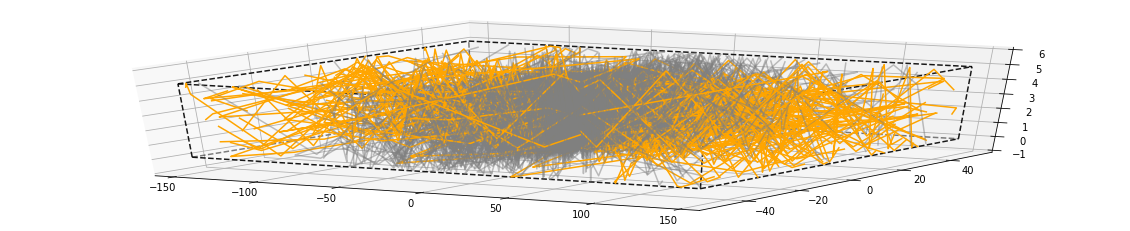

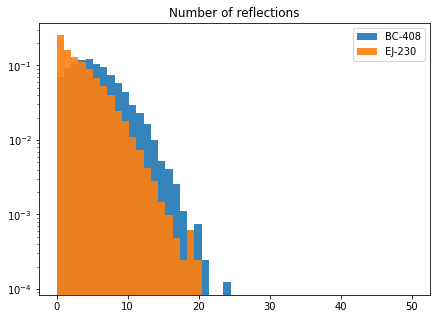

In [86]:

def reflectlines(ox,oy,oz,dx,dy,dz,delta,totlen,nrefmax,xbound,ybound,zbound):
    length=0.0
    x=[ox]
    y=[oy]
    z=[oz]
    i=0
    nref=0
    endz=[False,False]
    while length<totlen and nref<nrefmax:
        nextpos=[x[i]+dx*delta,y[i]+dy*delta,z[i]+dz*delta]
        if nextpos[0]<=xbound[0] or nextpos[0]>=xbound[1]:
            dx=-1*dx
            nref=nref+1
        if nextpos[1]<=ybound[0] or nextpos[1]>=ybound[1]:
            dy=-1*dy
            nref=nref+1
        if nextpos[2]<=zbound[0] or nextpos[2]>=zbound[1]:
            dz=-1*dz
            #nref=nref+1
            if nextpos[2]<=zbound[0]:
                endz[0]=True
            else:
                endz[1]=True
            break
        x.append(nextpos[0])
        y.append(nextpos[1])
        z.append(nextpos[2])
        length = length+delta
        i=i+1
    return x,y,z,endz

rndy=np.random.uniform(0,5,nprod)
#fig, ax = plt.subplots(3,1,figsize=(12,8))
#ax[0].set_xlim( -55, 55)
#ax[0].set_ylim(-1,6)
#ax[1].set_xlim(-155,155)
#ax[1].set_ylim(-1,6)

fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-155,155)
ax.set_ylim(-55,55)
ax.set_zlim(-1,6)

ax.plot([-150,-150],[+50,+50],[0,5],color='k',ls='--',alpha=0.5)
ax.plot([-150,+150],[+50,+50],[0,0],color='k',ls='--',alpha=0.5)
ax.plot([-150,+150],[+50,+50],[5,5],color='k',ls='--',alpha=0.9)
ax.plot([-150,-150],[-50,+50],[0,0],color='k',ls='--',alpha=0.5)
ax.plot([-150,-150],[-50,+50],[5,5],color='k',ls='--',alpha=0.9)
ax.plot([-150,-150],[-50,-50],[0,5],color='k',ls='--',alpha=0.9)
ax.plot([-150,+150],[-50,-50],[0,0],color='k',ls='--',alpha=0.9)
ax.plot([-150,+150],[-50,-50],[5,5],color='k',ls='--',alpha=0.9)
ax.plot([+150,+150],[-50,-50],[0,5],color='k',ls='--',alpha=0.9)
ax.plot([+150,+150],[-50,+50],[0,0],color='k',ls='--',alpha=0.9)
ax.plot([+150,+150],[-50,+50],[5,5],color='k',ls='--',alpha=0.9)
ax.plot([+150,+150],[+50,+50],[0,5],color='k',ls='--',alpha=0.9)

#### Calculate the number of allowed reflections
def getNumRef(ref):
    vanish=0
    prob=ref
    num=1
    while vanish==0:
        rnd=np.random.random()
        if rnd>prob:
            vanish=1
        else:
            prob = prob*ref
            num=num+1
    return num

narriveZ=[0,0,0,0,0,0]
#nev=nprod
nev=8000
numRefBC=[]
numRefEJ=[]
for i in range(nev):
    wl=dataBC[i]
    ref=fsp2(wl)/100.0 # Use the function for angle=0 just for now
    nRef=getNumRef(ref)
    numRefBC.append(nRef)
    x,y,z,endz=reflectlines(0,rndy[i],0,px[i],py[i],pz[i],0.1,attLength[0]*10,nRef,[-50,50],[0,5],[-150,150])
    if(i%10==0):
        color='gray'
        alpha=0.5
        if (endz[0]==True or endz[1]==True):
            color='orange'
            alpha=1.0
        #ax[0].plot(x,y)
        #ax[1].plot(z,y)
        ax.plot(z,x,y,color=color,alpha=alpha)
    if endz[0]==True:
        narriveZ[0]=narriveZ[0]+1
    if endz[1]==True:
        narriveZ[1]=narriveZ[1]+1
    #####################################
    # What if we use narrower counter??
    #####################################
    x,y,z,endz=reflectlines(0,rndy[i],0,px[i],py[i],pz[i],0.1,attLength[0]*10,nRef,[-40,40],[0,5],[-150,150])
    if endz[0]==True:
        narriveZ[2]=narriveZ[2]+1
    if endz[1]==True:
        narriveZ[3]=narriveZ[3]+1
    
    wl=dataEJ[i]
    ref=fsp2(wl)/100.0 # Use the function for angle=0 just for now
    nRef=getNumRef(ref)
    numRefEJ.append(nRef)
    x,y,z,endz=reflectlines(0,rndy[i],0,px[i],py[i],pz[i],0.1,attLength[0]*10,nRef,[-50,50],[0,5],[-150,150])
    if endz[0]==True:
        narriveZ[4]=narriveZ[4]+1
    if endz[1]==True:
        narriveZ[5]=narriveZ[5]+1
    
        
#print(narriveZ[0],narriveZ[1])

nsensors=6 ### Yet an arbitrary number..
pde=0.3
areaFrac=3*3*nsensors/(100*5)
print('Area fraction / AF*PDE / Expected # of photons at sensor')
print(areaFrac,pde,areaFrac*pde,areaFrac*pde*(narriveZ[0]/nev)*dE2L[0])
areaFrac=3*3*nsensors/(80*5) # for smaller width counter
print(areaFrac,pde,areaFrac*pde,areaFrac*pde*(narriveZ[2]/nev)*dE2L[0])
## EJ-230
areaFrac=3*3*nsensors/(100*5)
print(areaFrac,pde,areaFrac*pde,areaFrac*pde*(narriveZ[4]/nev)*dE2L[1])

fig = plt.figure(figsize=(7,5))
xbin=np.linspace(0,50,50)
plt.title('Number of reflections')
plt.hist(numRefBC,bins=xbin,density=True,alpha=0.9,label='BC-408')
plt.hist(numRefEJ,bins=xbin,density=True,alpha=0.9,label='EJ-230')
plt.legend(loc='upper right')
plt.yscale('Log')
plt.show()

In [87]:
print(np.array(numRefBC).mean(),np.array(numRefEJ).mean())

5.835125 3.8135
